In [2]:
pip install seaborn folium dash==2.15.0 jupyter-dash

In [4]:
# ====================================================
# ⬛ 1. Setup & Imports
# ====================================================
import requests, json, re, sqlite3, math, warnings, os, io, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
print("Libraries imported.")


Libraries imported.


In [5]:
# ====================================================
# ⬛ 2. SpaceX API Data Collection
# ====================================================
api_url = "https://api.spacexdata.com/v4/launches"
launches_raw = requests.get(api_url).json()

# Normalize nested JSON to flat table
launch_df = pd.json_normalize(
    launches_raw,
    record_path=["cores"],
    meta=[
        "name", "date_utc", "date_local", "flight_number",
        ["rocket"],
        ["payloads"],
        ["launchpad"]
    ],
    errors="ignore"
)
launch_df.head()


,core,flight,gridfins,legs,reused,landing_attempt,landing_success,landing_type,landpad,name,date_utc,date_local,flight_number,rocket,payloads,launchpad
0,5e9e289df35918033d3b2623,1.0,False,False,False,False,None,None,None,FalconSat,2006-03-24T22:30:00.000Z,2006-03-25T10:30:00+12:00,1,5e9d0d95eda69955f709d1eb,[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86
1,5e9e289ef35918416a3b2624,1.0,False,False,False,False,None,None,None,DemoSat,2007-03-21T01:10:00.000Z,2007-03-21T13:10:00+12:00,2,5e9d0d95eda69955f709d1eb,[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86
2,5e9e289ef3591814873b2625,1.0,False,False,False,False,None,None,None,Trailblazer,2008-08-03T03:34:00.000Z,2008-08-03T15:34:00+12:00,3,5e9d0d95eda69955f709d1eb,"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...",5e9e4502f5090995de566f86
3,5e9e289ef3591855dc3b2626,1.0,False,False,False,False,None,None,None,RatSat,2008-09-28T23:15:00.000Z,2008-09-28T11:15:00+12:00,4,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86
4,5e9e289ef359184f103b2627,1.0,False,False,False,False,None,None,None,RazakSat,2009-07-13T03:35:00.000Z,2009-07-13T15:35:00+12:00,5,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86


In [6]:
# Keep only Falcon 9 launches (rocket name retrieved in next call)
rockets = {r["id"]: r["name"] for r in requests.get("https://api.spacexdata.com/v4/rockets").json()}
launch_df["rocket_name"] = launch_df["rocket"].map(rockets)
launch_df = launch_df[launch_df["rocket_name"].str.contains("Falcon 9", na=False)].copy()

# ----------------------------------------------------
# Pull payload table for mass / orbit details
payloads = requests.get("https://api.spacexdata.com/v4/payloads").json()
payload_df = pd.json_normalize(payloads)[["id", "mass_kg", "orbit"]]
payload_df.columns = ["payload_id", "payload_mass_kg", "orbit"]

launch_df = launch_df.explode("payloads")
launch_df = launch_df.merge(payload_df, left_on="payloads", right_on="payload_id", how="left")
launch_df.head()


,core,flight,gridfins,legs,reused,landing_attempt,landing_success,landing_type,landpad,name,date_utc,date_local,flight_number,rocket,payloads,launchpad,rocket_name,payload_id,payload_mass_kg,orbit
0,5e9e289ef359185f2b3b2628,1.0,False,False,False,False,None,None,None,Falcon 9 Test Flight,2010-06-04T18:45:00.000Z,2010-06-04T14:45:00-04:00,6,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,Falcon 9,5eb0e4b7b6c3bb0006eeb1e7,NaN,LEO
1,5e9e289ef35918187c3b2629,1.0,False,False,False,False,None,None,None,COTS 1,2010-12-08T15:43:00.000Z,2010-12-08T11:43:00-04:00,7,5e9d0d95eda69973a809d1ec,5eb0e4b9b6c3bb0006eeb1e8,5e9e4501f509094ba4566f84,Falcon 9,5eb0e4b9b6c3bb0006eeb1e8,NaN,LEO
2,5e9e289ef35918187c3b2629,1.0,False,False,False,False,None,None,None,COTS 1,2010-12-08T15:43:00.000Z,2010-12-08T11:43:00-04:00,7,5e9d0d95eda69973a809d1ec,5eb0e4b9b6c3bb0006eeb1e9,5e9e4501f509094ba4566f84,Falcon 9,5eb0e4b9b6c3bb0006eeb1e9,NaN,LEO
3,5e9e289ef35918f39c3b262a,1.0,False,False,False,False,None,None,None,COTS 2,2012-05-22T07:44:00.000Z,2012-05-22T03:44:00-04:00,8,5e9d0d95eda69973a809d1ec,5eb0e4bab6c3bb0006eeb1ea,5e9e4501f509094ba4566f84,Falcon 9,5eb0e4bab6c3bb0006eeb1ea,525.0,LEO
4,5e9e289ff3591821a73b262b,1.0,False,False,False,False,None,None,None,CRS-1,2012-10-08T00:35:00.000Z,2012-10-08T20:35:00-04:00,9,5e9d0d95eda69973a809d1ec,5eb0e4bab6c3bb0006eeb1eb,5e9e4501f509094ba4566f84,Falcon 9,5eb0e4bab6c3bb0006eeb1eb,400.0,ISS


In [7]:
# ====================================================
# ⬛ 3. Web-Scraping Falcon 9 Launch History (Wikipedia)
# ====================================================
from bs4 import BeautifulSoup

wiki_url = "https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches"
soup = BeautifulSoup(requests.get(wiki_url).text, "html.parser")
falcon_tables = pd.read_html(str(soup.select("table.wikitable")[0]))[0]
falcon_tables.head()


,Flight No.,Date and time (UTC),"Version, booster[h]",Launch site,Payload[i],Payload mass,Orbit,Customer,Launch outcome,Booster landing
0,195,"January 3, 2023 14:56[17]",F9 B5 B1060‑15,"Cape Canaveral, SLC‑40",Transporter-6 (115 payload smallsat rideshare),Unknown[j],SSO,Various,Success,Success (LZ‑1)
1,195,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...
2,196,"January 10, 2023 04:50[23]",F9 B5 B1076‑2,"Cape Canaveral, SLC‑40",OneWeb 16 (40 satellites),"6,000 kg (13,000 lb)",Polar LEO,OneWeb,Success,Success (LZ‑1)
3,196,"Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One..."
4,FH 5,"January 15, 2023 22:56[29]",Falcon Heavy B5 B1070 (core),"Kennedy, LC‑39A",USSF-67 (CBAS-2 & LDPE-3A),"~3,750 kg (8,270 lb)",GEO,USSF,Success,No attempt


In [8]:
# ====================================================
# ⬛ 4. Data Wrangling & Feature Engineering
# ====================================================
df = launch_df.copy()

# --- Clean / convert columns ---
df["date_utc"] = pd.to_datetime(df["date_utc"])
df.rename(columns={
    "flight_number": "FlightNumber",
    "payload_mass_kg": "PayloadMass",
    "orbit": "Orbit",
    "launchpad": "LaunchSite"
}, inplace=True)

# --- Fill missing payload mass ---
df["PayloadMass"].fillna(df["PayloadMass"].mean(), inplace=True)

# --- Landing outcome label (Success=1, else 0) ---
df["landing_success"] = df["landing_success"].fillna(False).astype(int)

# --- One-hot encode Orbit & LaunchSite ---
categorical_cols = ["Orbit", "LaunchSite"]
df = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols)

df.head()


,core,flight,gridfins,legs,reused,landing_attempt,landing_success,landing_type,landpad,name,...,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO,LaunchSite_5e9e4501f509094ba4566f84,LaunchSite_5e9e4502f509092b78566f87,LaunchSite_5e9e4502f509094188566f88
0,5e9e289ef359185f2b3b2628,1.0,False,False,False,False,0,None,None,Falcon 9 Test Flight,...,True,False,False,False,False,False,False,True,False,False
1,5e9e289ef35918187c3b2629,1.0,False,False,False,False,0,None,None,COTS 1,...,True,False,False,False,False,False,False,True,False,False
2,5e9e289ef35918187c3b2629,1.0,False,False,False,False,0,None,None,COTS 1,...,True,False,False,False,False,False,False,True,False,False
3,5e9e289ef35918f39c3b262a,1.0,False,False,False,False,0,None,None,COTS 2,...,True,False,False,False,False,False,False,True,False,False
4,5e9e289ff3591821a73b262b,1.0,False,False,False,False,0,None,None,CRS-1,...,False,False,False,False,False,False,False,True,False,False


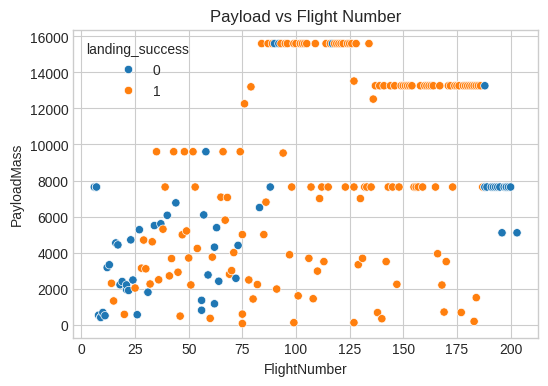

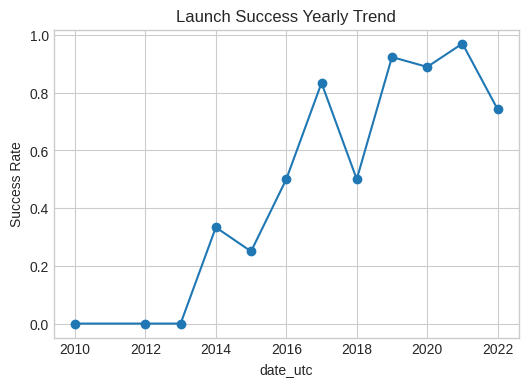

In [9]:
# ====================================================
# ⬛ 5. Exploratory Data Analysis (Visuals)
# ====================================================
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="FlightNumber", y="PayloadMass", hue="landing_success")
plt.title("Payload vs Flight Number")
plt.show()

plt.figure(figsize=(6,4))
df.groupby(df["date_utc"].dt.year)["landing_success"].mean().plot(marker="o")
plt.ylabel("Success Rate")
plt.title("Launch Success Yearly Trend")
plt.show()


In [10]:
# ====================================================
# ⬛ 6. SQL Analysis with SQLite
# ====================================================
conn = sqlite3.connect(":memory:")
df.to_sql("SPACEXTBL", conn, index=False, if_exists="replace")

query = """
SELECT substr(date_utc,1,4) AS Year,
       COUNT(*) AS Launches,
       ROUND(AVG(landing_success)*100,1) AS SuccessPct
FROM SPACEXTBL
GROUP BY Year
ORDER BY Year;
"""
sql_yearly = pd.read_sql_query(query, conn)
sql_yearly.head()


,Year,Launches,SuccessPct
0,2010,3,0.0
1,2012,3,0.0
2,2013,3,0.0
3,2014,6,33.3
4,2015,8,25.0


In [20]:
# === Show ALL column names and the first few rows ===
print("df.columns ➜", df.columns.tolist())
display(df.head(3))


df.columns ➜ ['core', 'flight', 'gridfins', 'legs', 'reused', 'landing_attempt', 'landing_success', 'landing_type', 'landpad', 'name', 'date_utc', 'date_local', 'FlightNumber', 'rocket', 'payloads', 'rocket_name', 'payload_id', 'PayloadMass', 'Orbit_ES-L1', 'Orbit_GEO', 'Orbit_GTO', 'Orbit_HEO', 'Orbit_ISS', 'Orbit_LEO', 'Orbit_MEO', 'Orbit_PO', 'Orbit_SO', 'Orbit_SSO', 'Orbit_TLI', 'Orbit_VLEO', 'LaunchSite_5e9e4501f509094ba4566f84', 'LaunchSite_5e9e4502f509092b78566f87', 'LaunchSite_5e9e4502f509094188566f88']


,core,flight,gridfins,legs,reused,landing_attempt,landing_success,landing_type,landpad,name,...,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO,LaunchSite_5e9e4501f509094ba4566f84,LaunchSite_5e9e4502f509092b78566f87,LaunchSite_5e9e4502f509094188566f88
0,5e9e289ef359185f2b3b2628,1.0,False,False,False,False,0,None,None,Falcon 9 Test Flight,...,True,False,False,False,False,False,False,True,False,False
1,5e9e289ef35918187c3b2629,1.0,False,False,False,False,0,None,None,COTS 1,...,True,False,False,False,False,False,False,True,False,False
2,5e9e289ef35918187c3b2629,1.0,False,False,False,False,0,None,None,COTS 1,...,True,False,False,False,False,False,False,True,False,False


In [23]:
# ====================================================
# 7 ▸ Folium Map (handles one-hot LaunchSite columns)
# ====================================================
import folium, requests, pandas as pd
from folium.plugins import MarkerCluster

# 1) Build lookup table (pad_id ➜ pad_name, lat, lon)
pads_json = requests.get("https://api.spacexdata.com/v4/launchpads").json()
pad_df = pd.json_normalize(pads_json)[["id", "name", "latitude", "longitude"]]
pad_df.columns = ["pad_id", "pad_name", "lat", "lon"]

# 2) Find pad IDs from one-hot columns like 'LaunchSite_<padid>'
onehot_cols = [c for c in df.columns if c.startswith("LaunchSite_")]
if not onehot_cols:
    raise KeyError("No LaunchSite_* dummy columns found. Check your dataframe.")

pad_ids = [c.split("LaunchSite_")[1] for c in onehot_cols]

# 3) Get unique pad rows for the map
site_df = pd.DataFrame({"pad_id": pad_ids}).drop_duplicates()
site_df = site_df.merge(pad_df, on="pad_id", how="left")

# 4) Build the Folium map
m = folium.Map(location=[site_df["lat"].mean(), site_df["lon"].mean()], zoom_start=3)
cluster = MarkerCluster().add_to(m)

for _, r in site_df.iterrows():
    folium.Marker(
        location=[r["lat"], r["lon"]],
        popup=r["pad_name"]
    ).add_to(cluster)

m  # displays map


In [26]:
# ====================================================
# 8 ▸ Classification Models (fixed for string columns)
# ====================================================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# 1️⃣ Remove obvious non-feature columns
drop_cols = [
    "core", "name", "date_utc", "date_local",
    "rocket", "payloads", "payload_id", "rocket_name"
]
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore").copy()

# 2️⃣ Separate target and features
y = df_model["landing_success"]
X = df_model.drop("landing_success", axis=1)

# 3️⃣ One-hot encode any remaining object/string columns
obj_cols = X.select_dtypes(include="object").columns
if len(obj_cols):
    X = pd.get_dummies(X, columns=obj_cols, drop_first=True)
    print("One-hot encoded:", list(obj_cols))

# 4️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5️⃣ Define models & grids
models = {
    "SVM": (SVC(), {"model__kernel": ["linear", "rbf"], "model__C": [0.1, 1, 10]}),
    "Decision Tree": (DecisionTreeClassifier(), {"model__max_depth": [5, 10, None]}),
    "KNN": (KNeighborsClassifier(), {"model__n_neighbors": [3, 5, 7]}),
}

results, best_models = {}, {}

for name, (base_model, grid) in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),  # with_mean=False for sparse data
        ("model", base_model)
    ])
    gs = GridSearchCV(pipe, grid, cv=5, scoring="accuracy", n_jobs=-1)
    gs.fit(X_train, y_train)

    y_pred = gs.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    best_models[name] = gs.best_estimator_

    print(f"{name:<14}  accuracy = {acc:.3f}  best_params = {gs.best_params_}")

# 6️⃣ Accuracy bar chart
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color="skyblue")
plt.title("Classification Accuracies")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
plt.show()

# 7️⃣ Confusion matrix for best model
best_name = max(results, key=results.get)
print("Best model:", best_name)
ConfusionMatrixDisplay.from_estimator(best_models[best_name], X_test, y_test)
plt.title(f"{best_name} – Confusion Matrix")
plt.show()


One-hot encoded: ['gridfins', 'legs', 'reused', 'landing_attempt', 'landing_type', 'landpad', 'FlightNumber']


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 197, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


SVM           | accuracy=0.905 | best_params={'model__C': 1, 'model__kernel': 'rbf'}
Decision Tree | accuracy=0.881 | best_params={'model__max_depth': 5}
KNN           | accuracy=0.857 | best_params={'model__n_neighbors': 7}


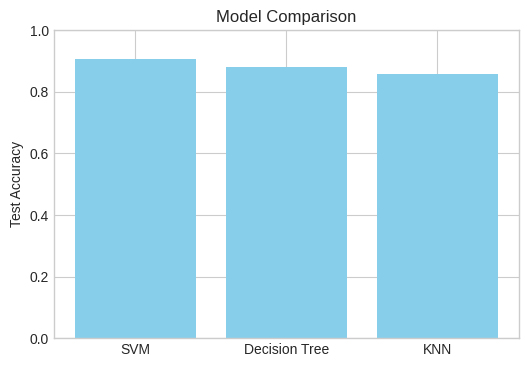

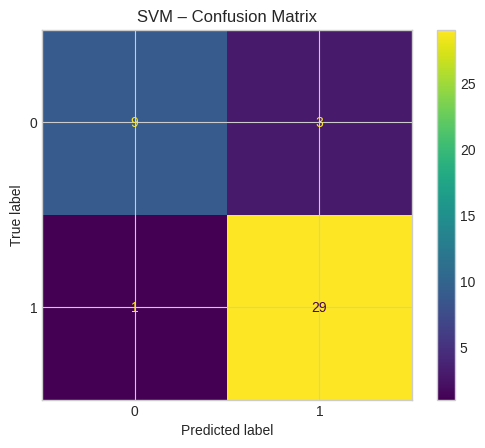

In [28]:
# ====================================================
# 8 ▸ Classification (imputation + scaling)
# ====================================================
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# 1️⃣  Drop obvious non-features
drop_cols = [
    "core", "name", "date_utc", "date_local",
    "rocket", "payloads", "payload_id", "rocket_name"
]
df_mod = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore").copy()

# 2️⃣  Separate y and X
y = df_mod["landing_success"]
X = df_mod.drop("landing_success", axis=1)

# 3️⃣  One-hot any object columns
obj_cols = X.select_dtypes(include="object").columns
if len(obj_cols):
    X = pd.get_dummies(X, columns=obj_cols, drop_first=True)

# 4️⃣  Identify numeric columns (all should be numeric now)
num_cols = X.columns

# 5️⃣  Preprocess pipeline: impute NaN ➜ median, then scale
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ]), num_cols)
])

# 6️⃣  Models & grids
models = {
    "SVM": (SVC(), {"model__kernel": ["linear", "rbf"], "model__C": [0.1, 1, 10]}),
    "Decision Tree": (DecisionTreeClassifier(), {"model__max_depth": [5, 10, None]}),
    "KNN": (KNeighborsClassifier(), {"model__n_neighbors": [3, 5, 7]}),
}

# 7️⃣  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

results, best_models = {}, {}
for name, (estimator, param_grid) in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", estimator)])
    gs = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    gs.fit(X_train, y_train)

    y_pred = gs.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    best_models[name] = gs.best_estimator_

    print(f"{name:<13s} | accuracy={acc:.3f} | best_params={gs.best_params_}")

# 8️⃣  Accuracy bar chart
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color="skyblue")
plt.ylim(0,1); plt.ylabel("Test Accuracy"); plt.title("Model Comparison")
plt.show()

# 9️⃣  Confusion matrix for best model
best_name = max(results, key=results.get)
ConfusionMatrixDisplay.from_estimator(best_models[best_name], X_test, y_test)
plt.title(f"{best_name} – Confusion Matrix"); plt.show()


In [29]:
# ====================================================
# ⬛ 9. Save Processed Data (optional)
# ====================================================
df.to_csv("processed_spacex_data.csv", index=False)
print("Data saved to processed_spacex_data.csv")


Data saved to processed_spacex_data.csv
